In [67]:
library(plyr)
library(tidyverse)
library(reshape)
library(ggrepel)
library(imputeTS)
library(gridExtra)
library(viridis)
library(plotly)

### The goal is to examine if the treatment had an effect on the proteome when compared to control.
### Thus, our null hypothesis (h0) = Treatment had an effect on the proteome.
### And, our alternative hypotehsis (Ha) = Treatment had NO effect on the proteome.

In [2]:
df <- readr::read_tsv("ExampleData.txt")
head(df)


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────
cols(
  protein_id = col_character(),
  control_1 = col_double(),
  control_2 = col_double(),
  control_3 = col_double(),
  treatment_1 = col_double(),
  treatment_2 = col_double(),
  treatment_3 = col_double()
)




protein_id,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3
P38606,0.8114,0.8575,1.0381,0.6448,0.7190,0.4805
P18077,0.3672,0.3853,0.4091,0.4109,0.4634,0.3561
P35580,2.9815,4.6176,2.8709,7.1670,2.0052,0.8995
P84095,0.1424,0.2238,0.1281,0.1643,0.2466,0.1268
P25786,1.0748,0.9451,0.8032,0.7884,0.8798,0.7631
P30044,0.5663,0.5395,0.4876,0.5448,1.6897,0.8214


In [3]:
#Summary statistics of data:
summary(df)

  protein_id          control_1        control_2        control_3     
 Length:7702        Min.   : 0.001   Min.   : 0.000   Min.   : 0.001  
 Class :character   1st Qu.: 0.143   1st Qu.: 0.132   1st Qu.: 0.149  
 Mode  :character   Median : 0.345   Median : 0.322   Median : 0.388  
                    Mean   : 0.933   Mean   : 0.845   Mean   : 0.977  
                    3rd Qu.: 0.959   3rd Qu.: 0.845   3rd Qu.: 0.999  
                    Max.   :31.944   Max.   :31.697   Max.   :31.320  
                    NA's   :4888     NA's   :4828     NA's   :5087    
  treatment_1      treatment_2      treatment_3    
 Min.   : 0.000   Min.   : 0.002   Min.   : 0.002  
 1st Qu.: 0.112   1st Qu.: 0.135   1st Qu.: 0.101  
 Median : 0.286   Median : 0.319   Median : 0.254  
 Mean   : 0.795   Mean   : 0.856   Mean   : 0.675  
 3rd Qu.: 0.780   3rd Qu.: 0.880   3rd Qu.: 0.682  
 Max.   :41.686   Max.   :28.234   Max.   :21.428  
 NA's   :4739     NA's   :4902     NA's   :5074    

In [4]:
df %>% summarise(proteins_total = n()) 

#Total number of proteins in the dataframe (df).

proteins_total
7702


In [5]:
df_notnull <- df %>% drop_na()
df_notnull %>% summarise(proteins_total = n()) 

#We can see there are totally 1145 proteins without missing values which is an extremely small number.
#Hence to tackle this, can impute the data with the mean value.

proteins_total
1145


In [6]:
#Since the data contains missing values, I have replaced the missing values with mean:

df_imputed <- na_mean(df)
df_imputed[,-1] <-round(df_imputed[,-1],4)
tail(df_imputed)

#NOTE: The same analysis can be done for the imputed data and imputation is necessary in the later stages

protein_id,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3
Q96CS2,0.9325,0.8452,0.9768,0.7949,0.8558,0.6755
H0YIJ5,0.9325,0.8452,0.0116,0.7949,0.8558,0.6755
Q13939,0.9325,0.8452,0.9768,0.7949,0.8558,0.6755
A0A087WZ32,0.9325,0.8452,0.9768,0.7949,0.8558,0.6755
O60318,0.9325,0.8452,0.9768,0.7949,0.8558,0.6755
Q9NYQ3,0.9325,0.8452,0.9768,0.7949,0.8558,0.6755


### Density plot of non-normalized vs. quantile normalized data:

Warning message:
“Removed 305 rows containing non-finite values (stat_density).”


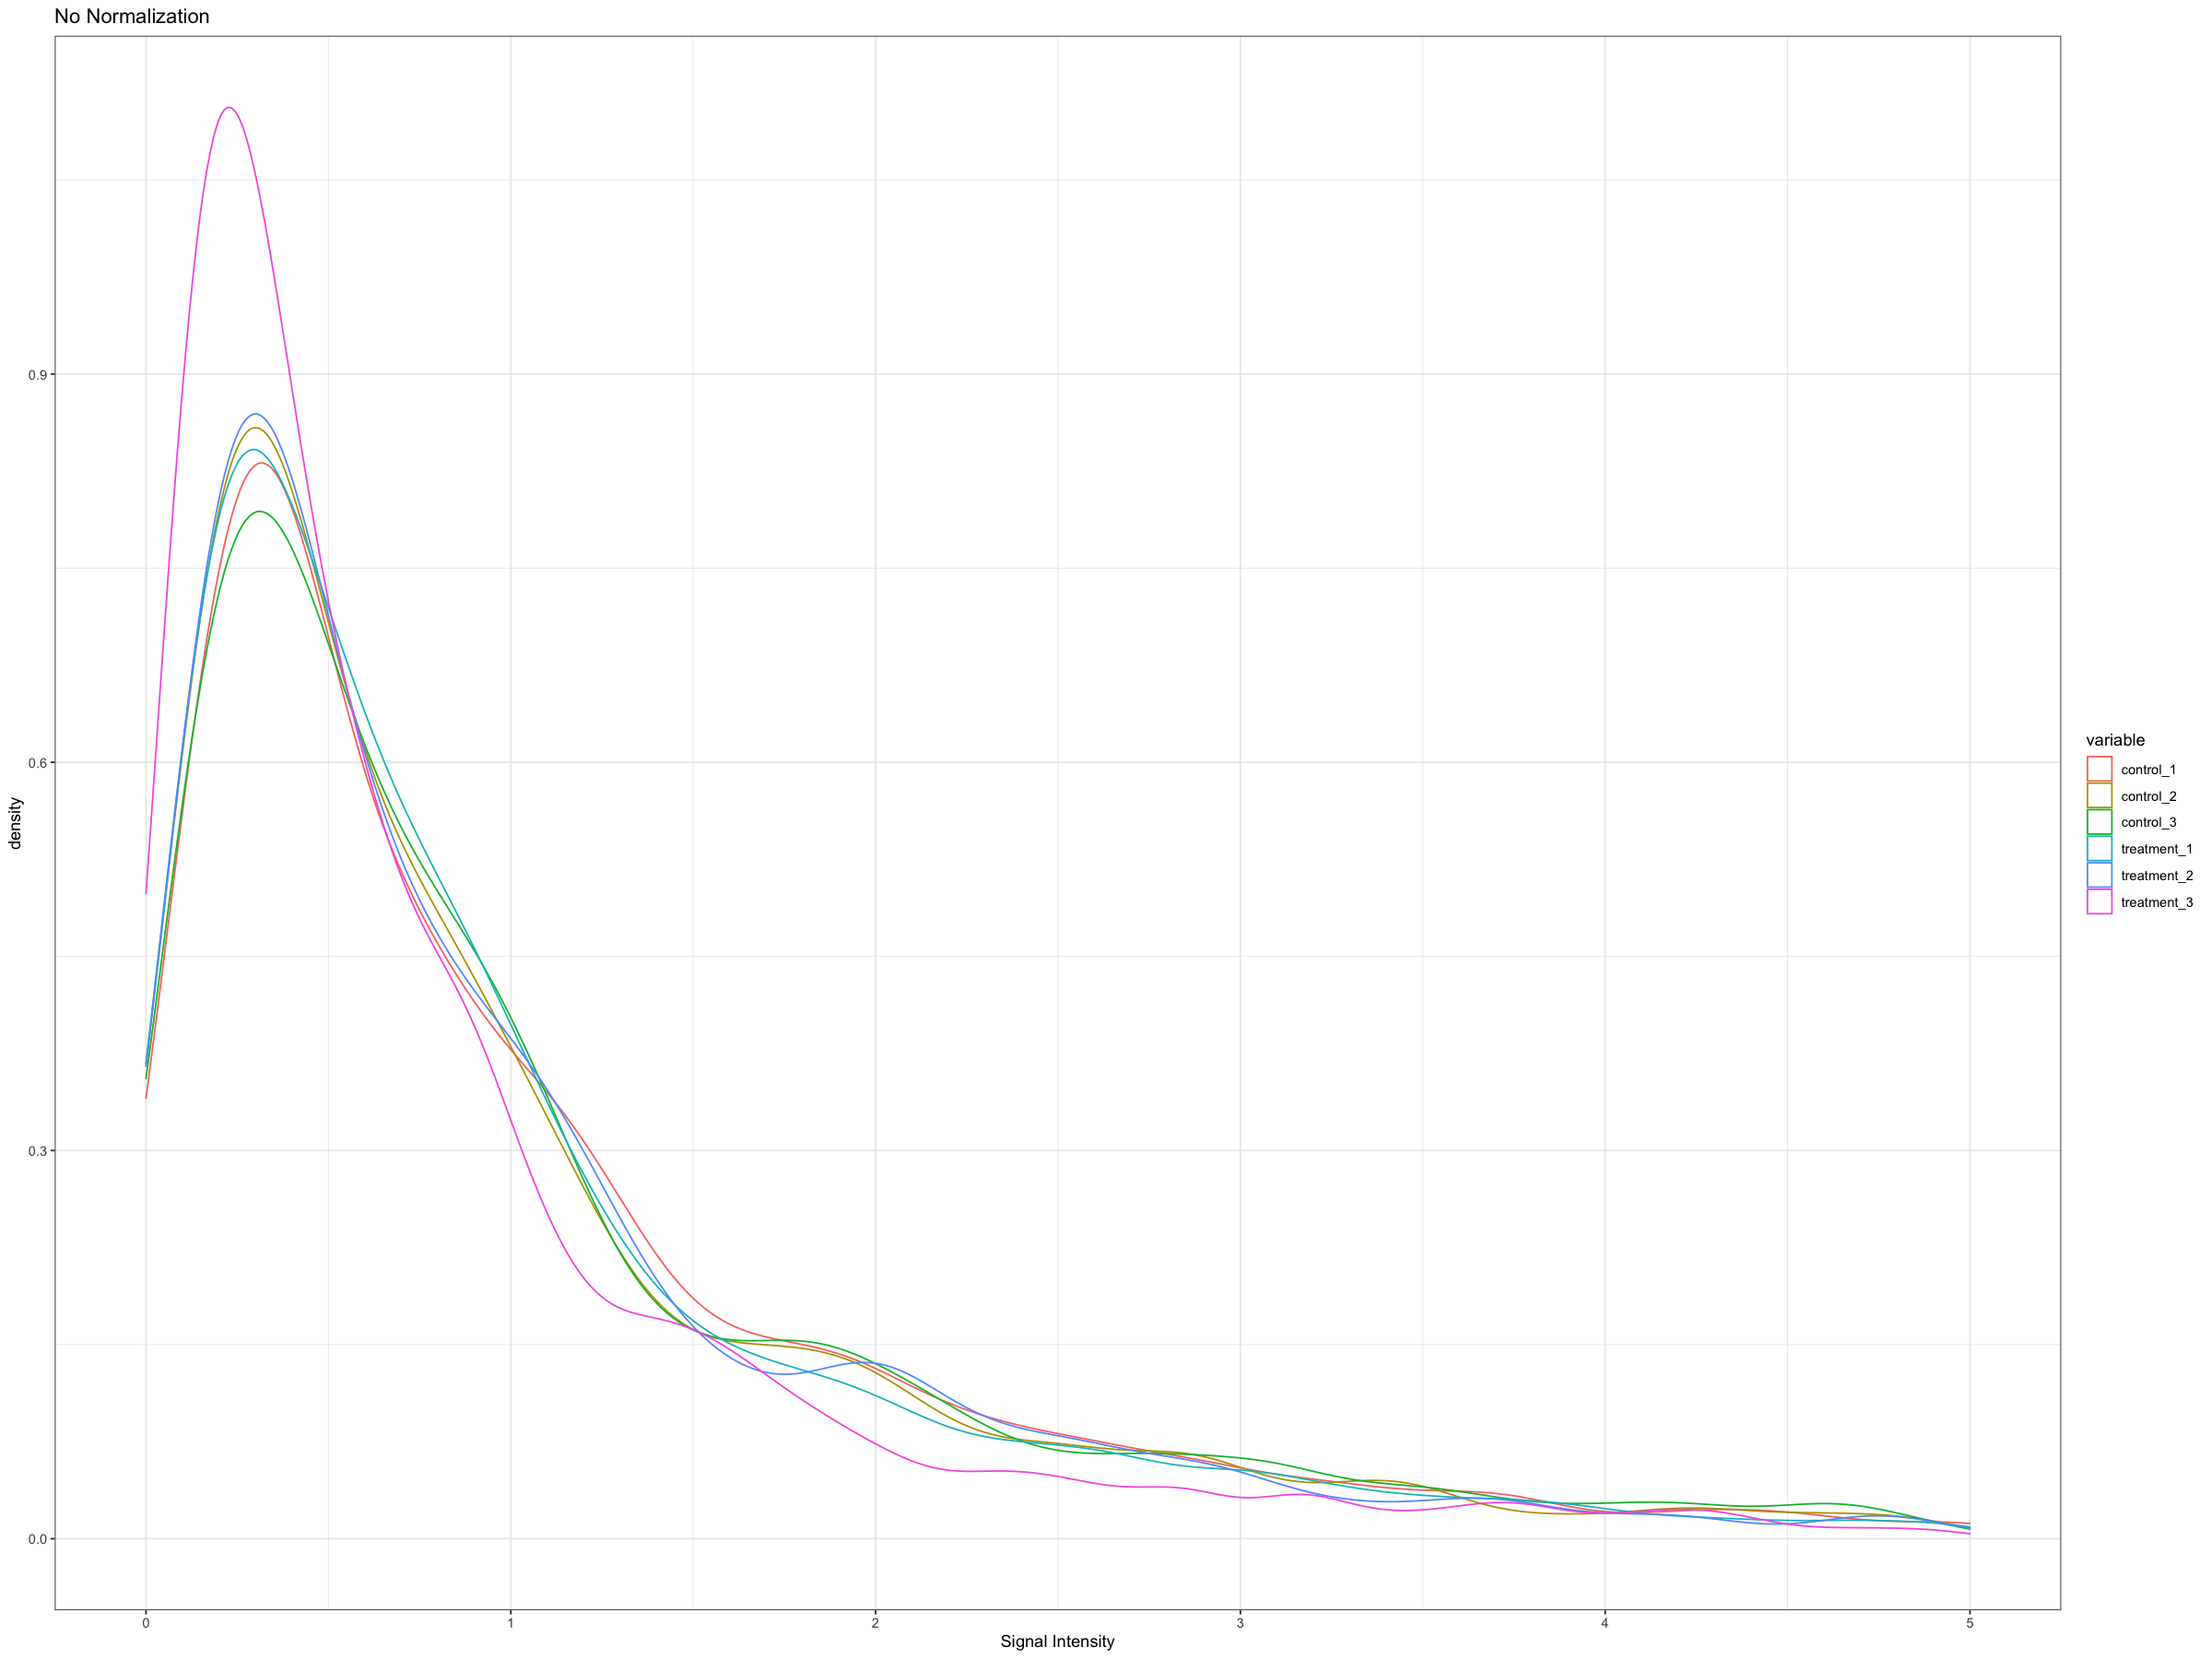

In [7]:
df_notnull_plot <- data.frame(df_notnull)
df_notnull_plot <- melt(df_notnull_plot, id.vars="protein_id")

options(repr.plot.width=20, repr.plot.height=15)
density_plot_1 <- ggplot(df_notnull_plot, aes(value, colour = variable)) + geom_density() + theme_bw() + xlim(0,5)  + ggtitle("No Normalization") + xlab("Signal Intensity")
density_plot_1

In [8]:
#Variation occurs since the same protein signal intesntiy will not be the same across samples
#This has to be normalized. I have normalized the data by performing quantile normalization as I'm most familiar with this.
#The steps for quantile normalization of data are as follows:
    #Step 1: Ranking data from lowest to highest 
    #Step 2: Sort from lowest to highest
    #Step 3: Calculate the mean
    #Step 4: Substitute the mean

quantileNormalization <- function(df){
  
    #Step 1:
    df_rank <- map_df(df,rank,ties.method="min")
    
    #Step 2
    df_sorted <- map_df(df,sort)
    
    #Step 3:
    df_mean <- apply(df_sorted, 1, mean)
    
    
    #Step 4:
    index_to_mean <- function(my_index, my_mean){
        return(my_mean[my_index])
  }
  
    df_final <- map_df(df_rank,index_to_mean, my_mean=df_mean)
  
    return(df_final)
}

df_normalized <- df_notnull %>% select(-(protein_id)) %>% quantileNormalization() %>% bind_cols(df_notnull[,1],.)
head(df_normalized)

protein_id,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3
P38606,0.7497667,0.8330000,0.9888833,0.6309167,0.7134667,0.6372667
P18077,0.3442667,0.3752500,0.3767833,0.3908167,0.4515333,0.4644500
P35580,2.8243667,4.5993833,2.6188667,6.8430833,1.9519167,1.1464333
P84095,0.1256000,0.2186000,0.1191500,0.1627833,0.2396167,0.1707000
P25786,0.9728667,0.9372167,0.7459500,0.7641000,0.8469667,0.9728667
P30044,0.5249167,0.5233000,0.4449000,0.5225333,1.6473000,1.0348167


Warning message:
“Removed 306 rows containing non-finite values (stat_density).”


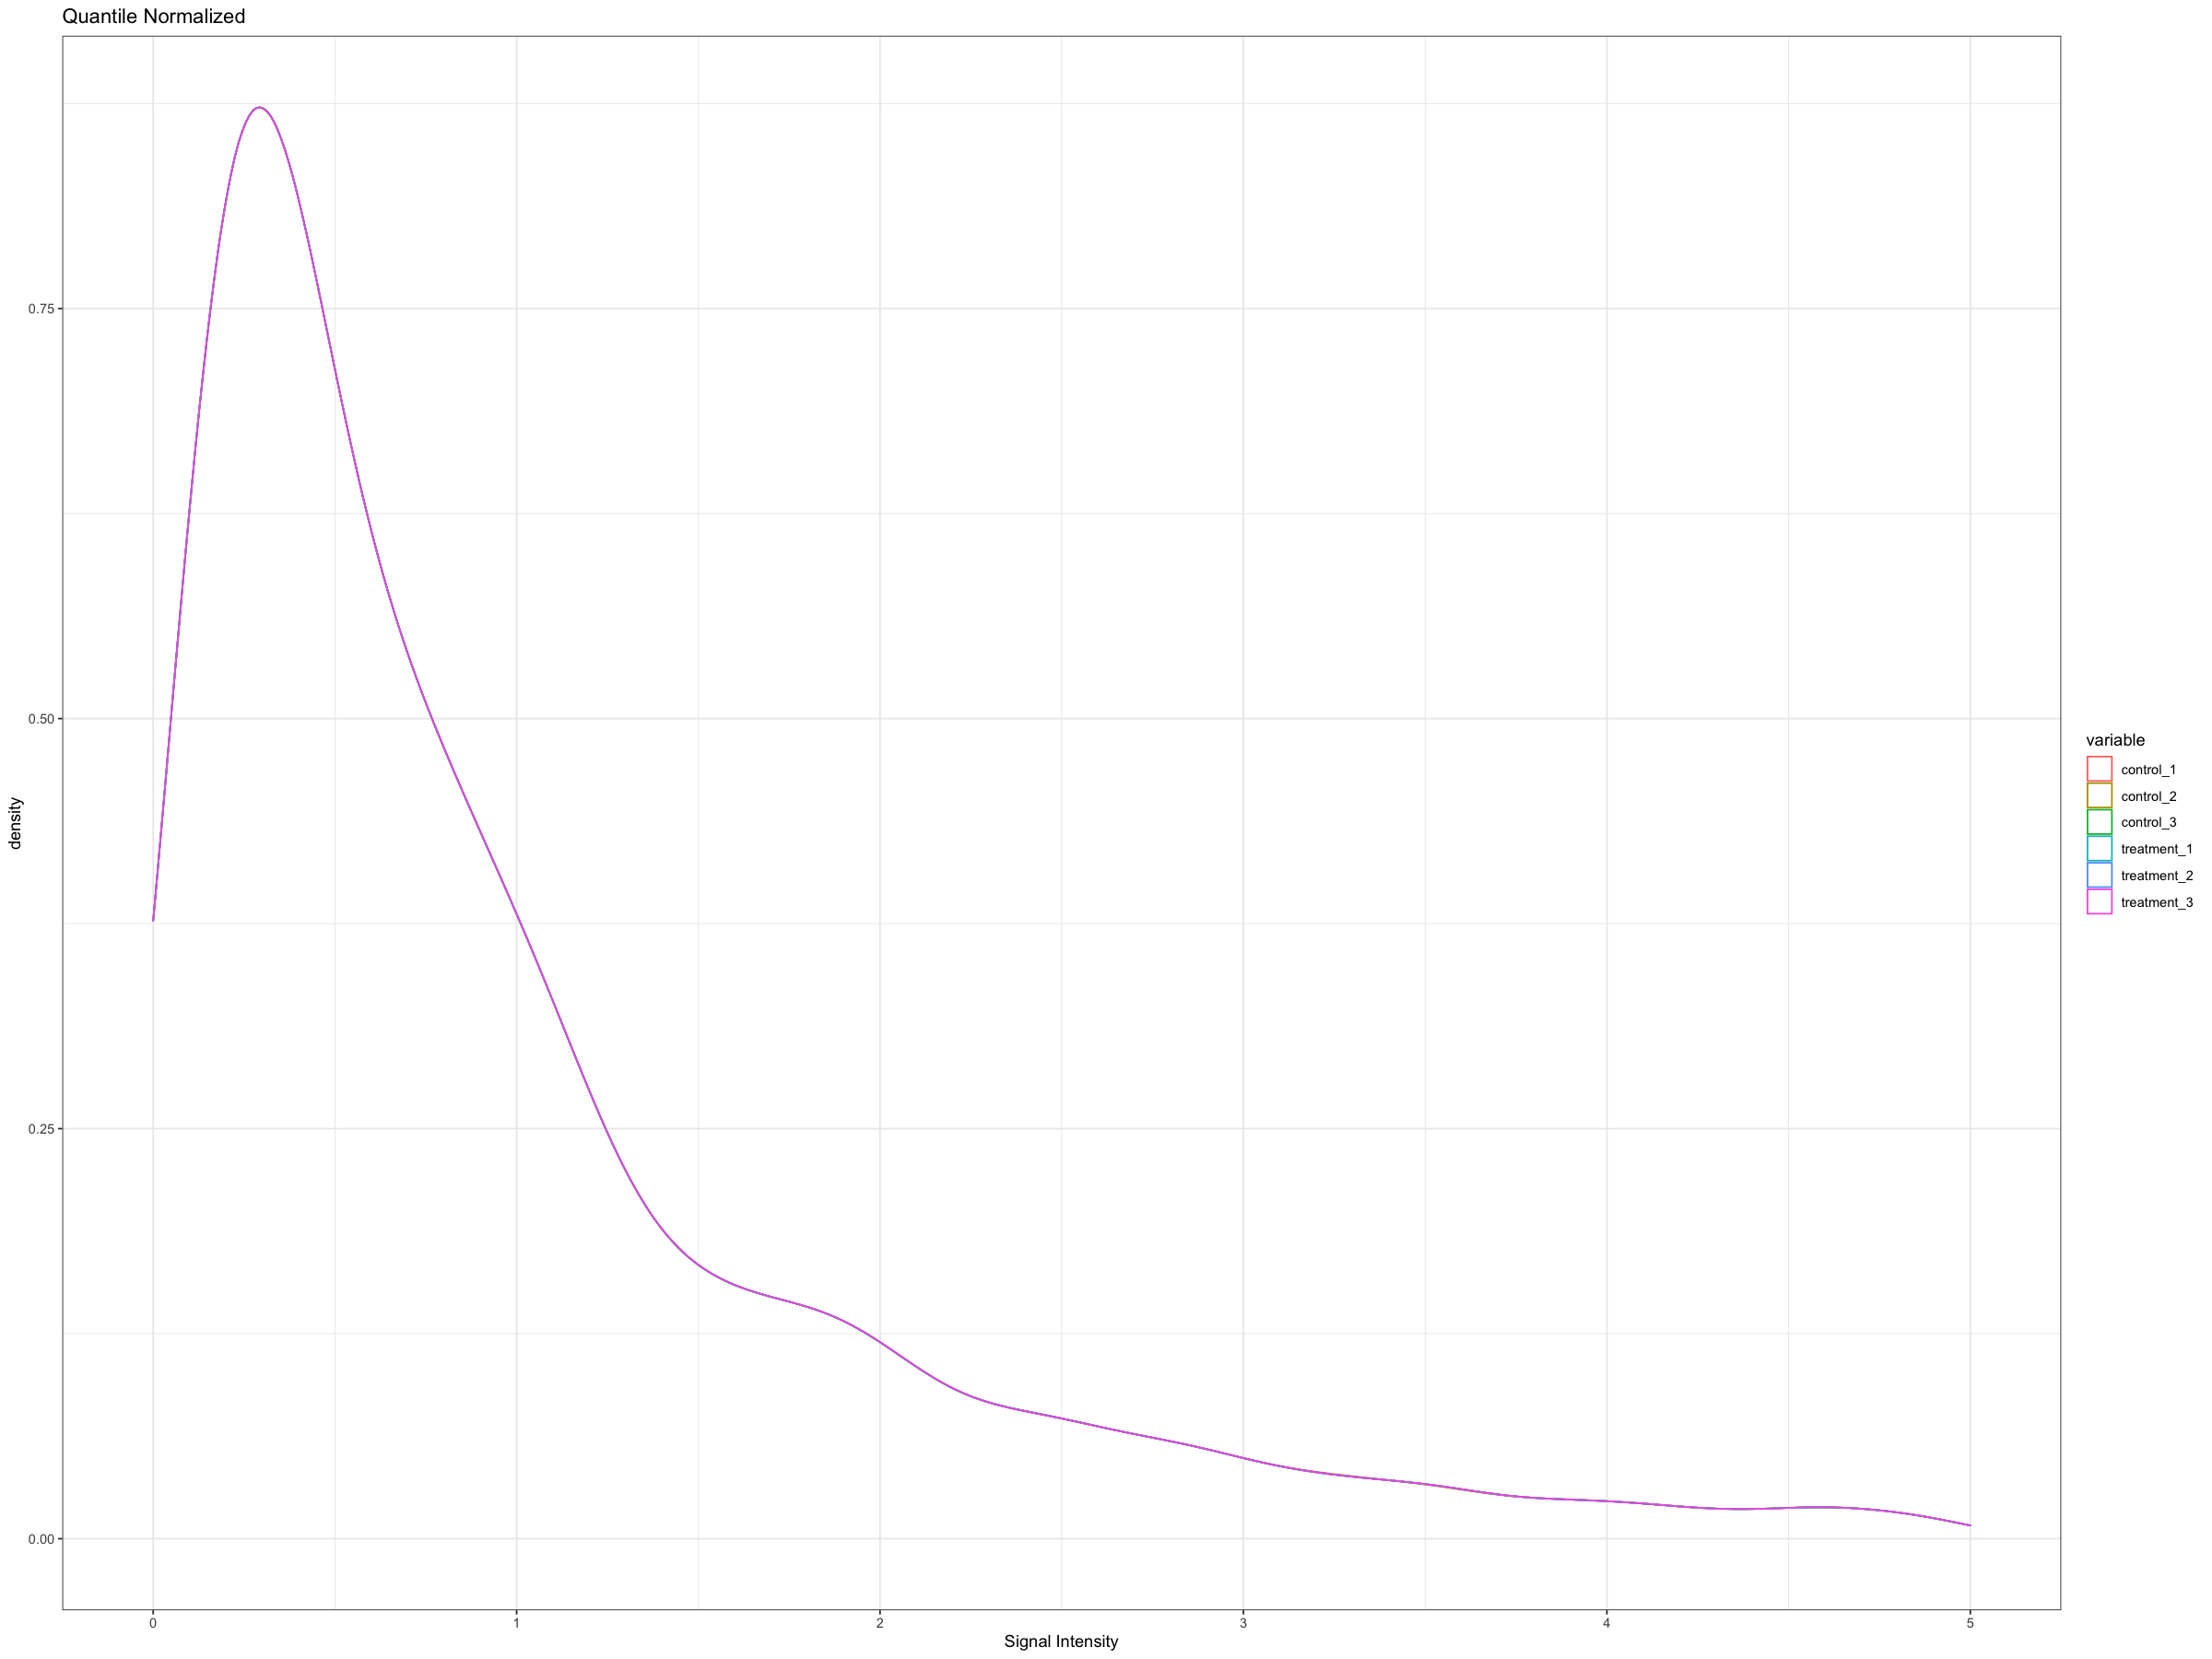

In [9]:
df_normalized_plot <- data.frame(df_normalized)
df_normalized_plot <- melt(df_normalized_plot, id.vars="protein_id")

options(repr.plot.width=20, repr.plot.height=15)
density_plot_2 <- ggplot(df_normalized_plot, aes(value, colour = variable)) + geom_density() + theme_bw() + xlim(0,5) + ggtitle("Quantile Normalized") + xlab("Signal Intensity")
density_plot_2

Warning message:
“Removed 305 rows containing non-finite values (stat_density).”
Warning message:
“Removed 306 rows containing non-finite values (stat_density).”


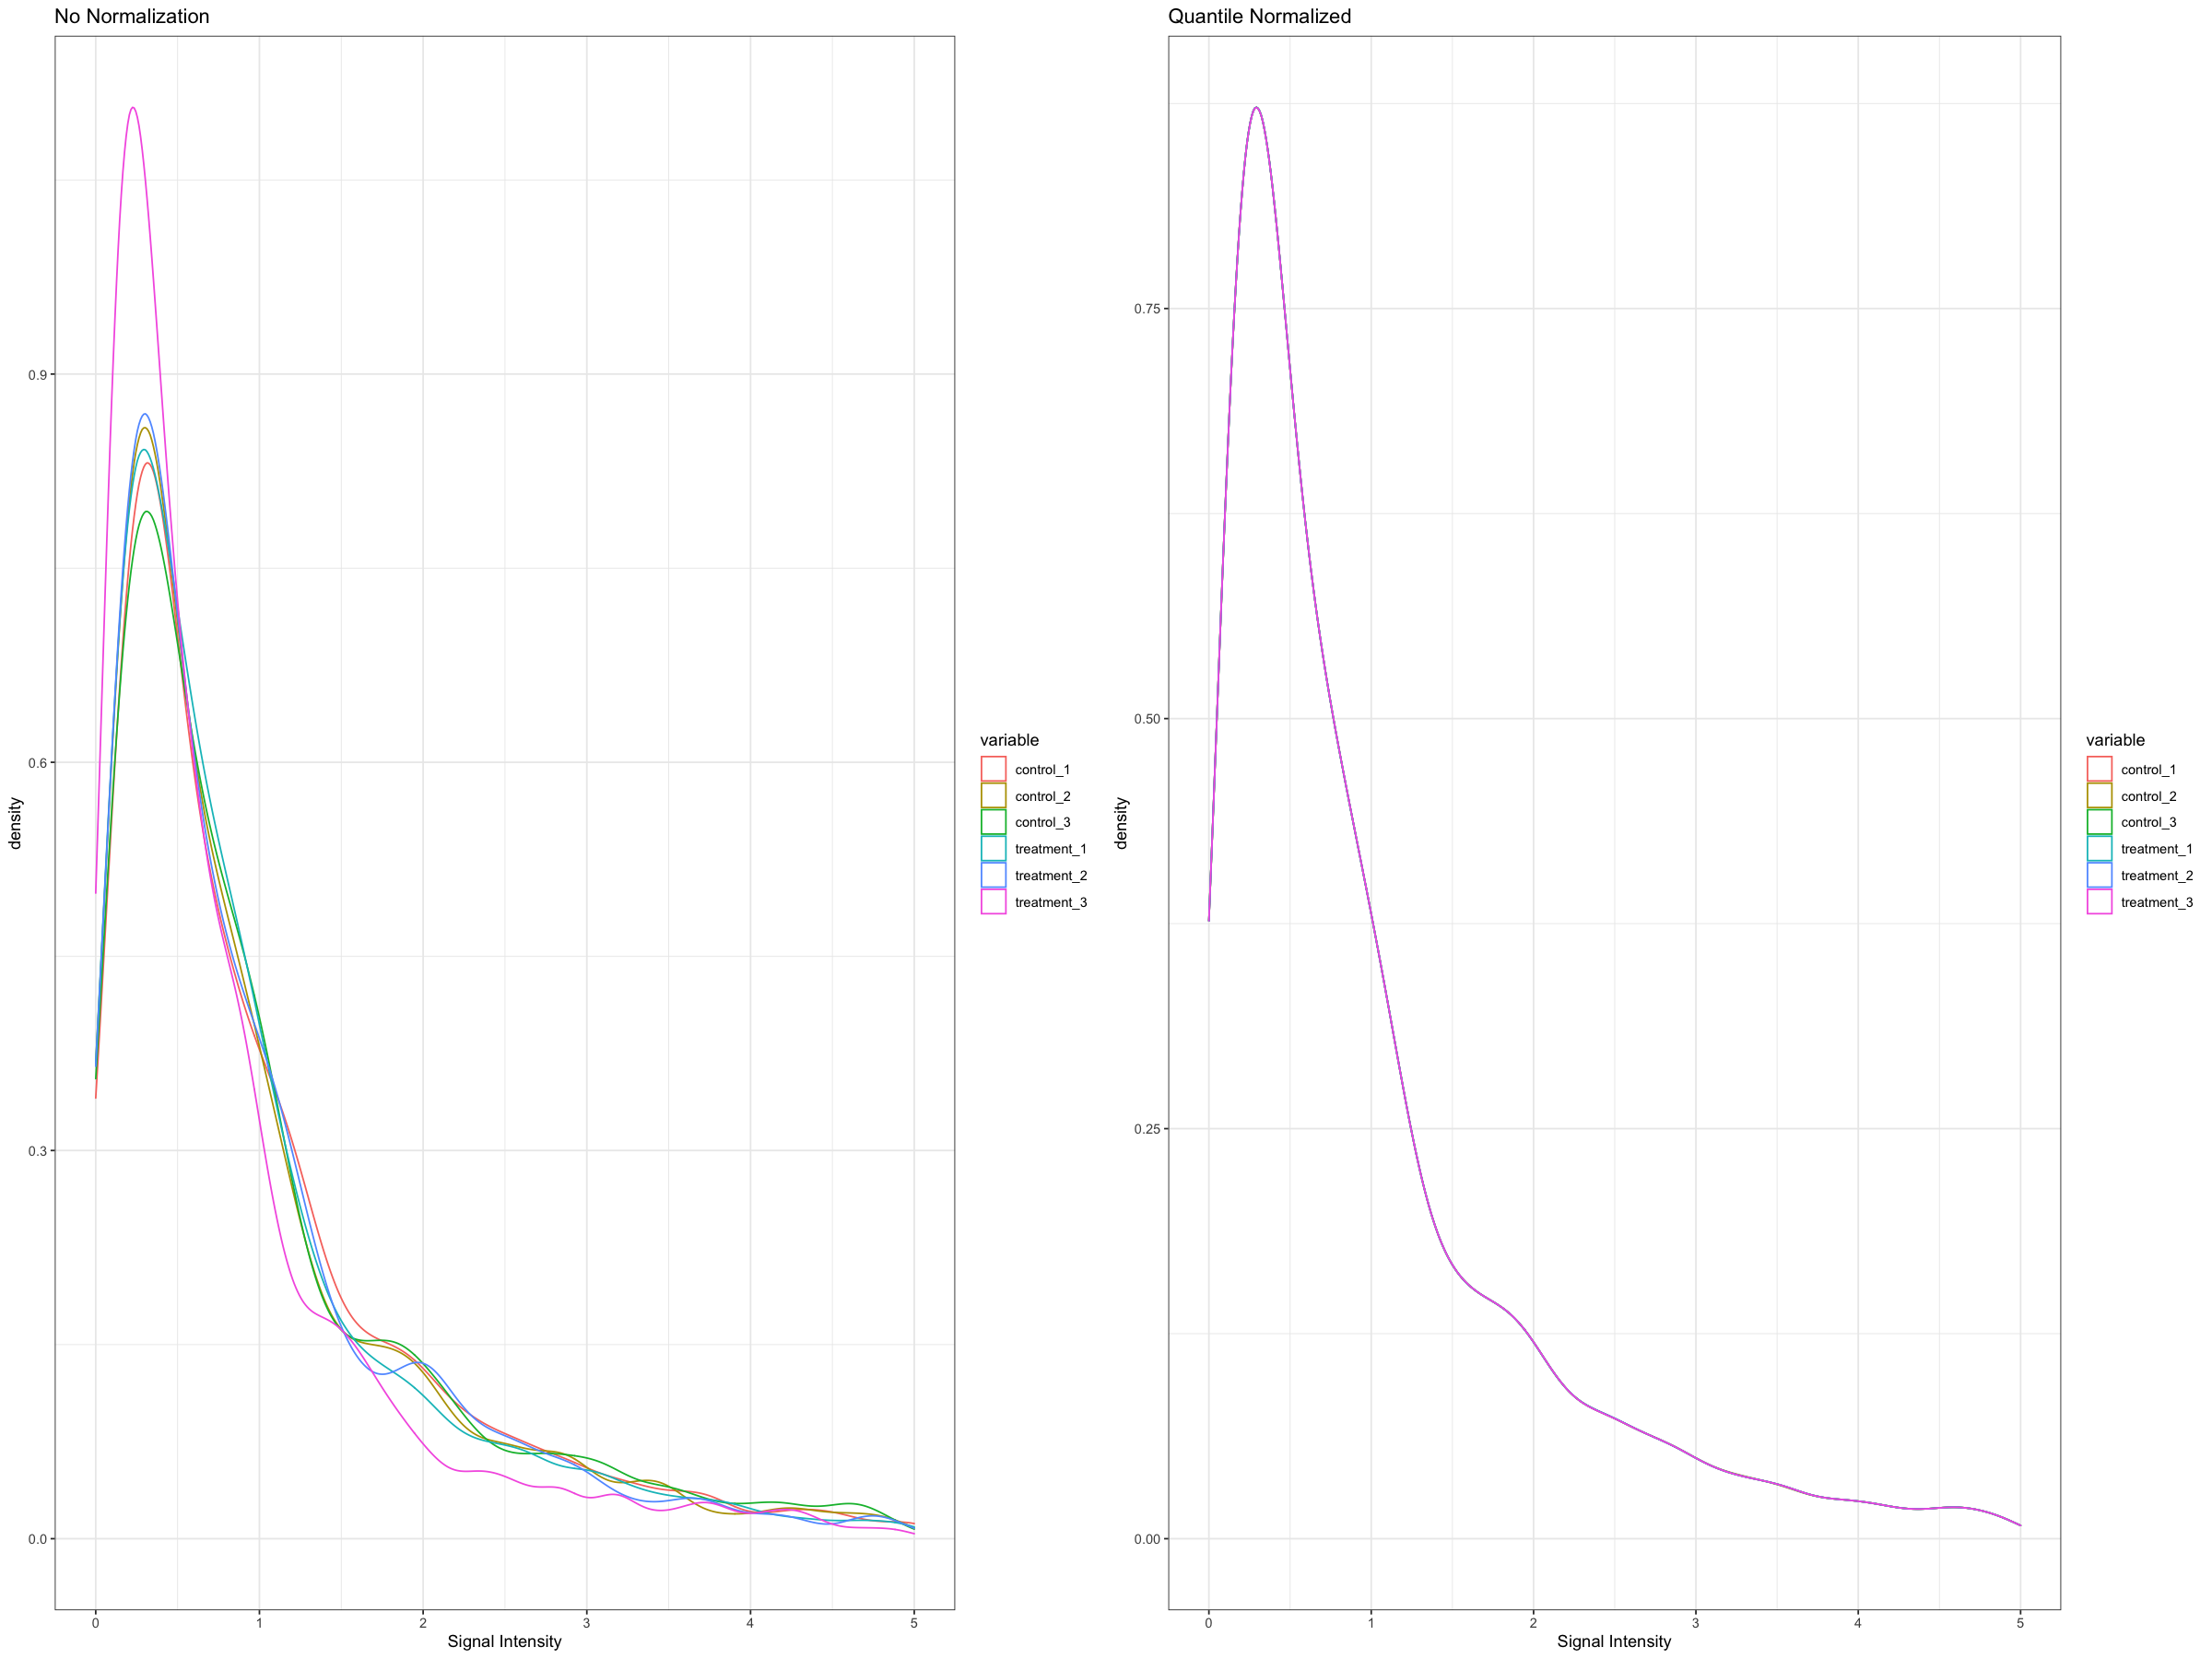

In [10]:
grid.arrange(density_plot_1, density_plot_2, nrow = 1)

### Performing a t-test in order to infer whether treatment is effective or not:

As our goal is to figure out if there is a difference between treatment and control and we are comparing two groups, a t-test can give us information on whether the difference is "real" or whether it is due to random chance. 

In [39]:
tTest <- function(df,group1,group2){
  control <- df[group1] %>% unlist %>% as.numeric()
  treatment <- df[group2] %>% unlist %>% as.numeric()
    
  result <- t.test(control, treatment)
    
  p_vals <- tibble(p_val = result$p.value)

  return(p_vals)
} 

df_pvals <- plyr::adply(df_normalized,.margins = 1, .fun = tTest, 
                group1 = c(2:4), group2 = c(5:7)) %>% as_tibble()

head(df_pvals)

protein_id,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3,p_val
P38606,0.7497667,0.8330000,0.9888833,0.6309167,0.7134667,0.6372667,0.09273622
P18077,0.3442667,0.3752500,0.3767833,0.3908167,0.4515333,0.4644500,0.07243830
P35580,2.8243667,4.5993833,2.6188667,6.8430833,1.9519167,1.1464333,0.98707595
P84095,0.1256000,0.2186000,0.1191500,0.1627833,0.2396167,0.1707000,0.41922937
P25786,0.9728667,0.9372167,0.7459500,0.7641000,0.8469667,0.9728667,0.80907701
P30044,0.5249167,0.5233000,0.4449000,0.5225333,1.6473000,1.0348167,0.22076341


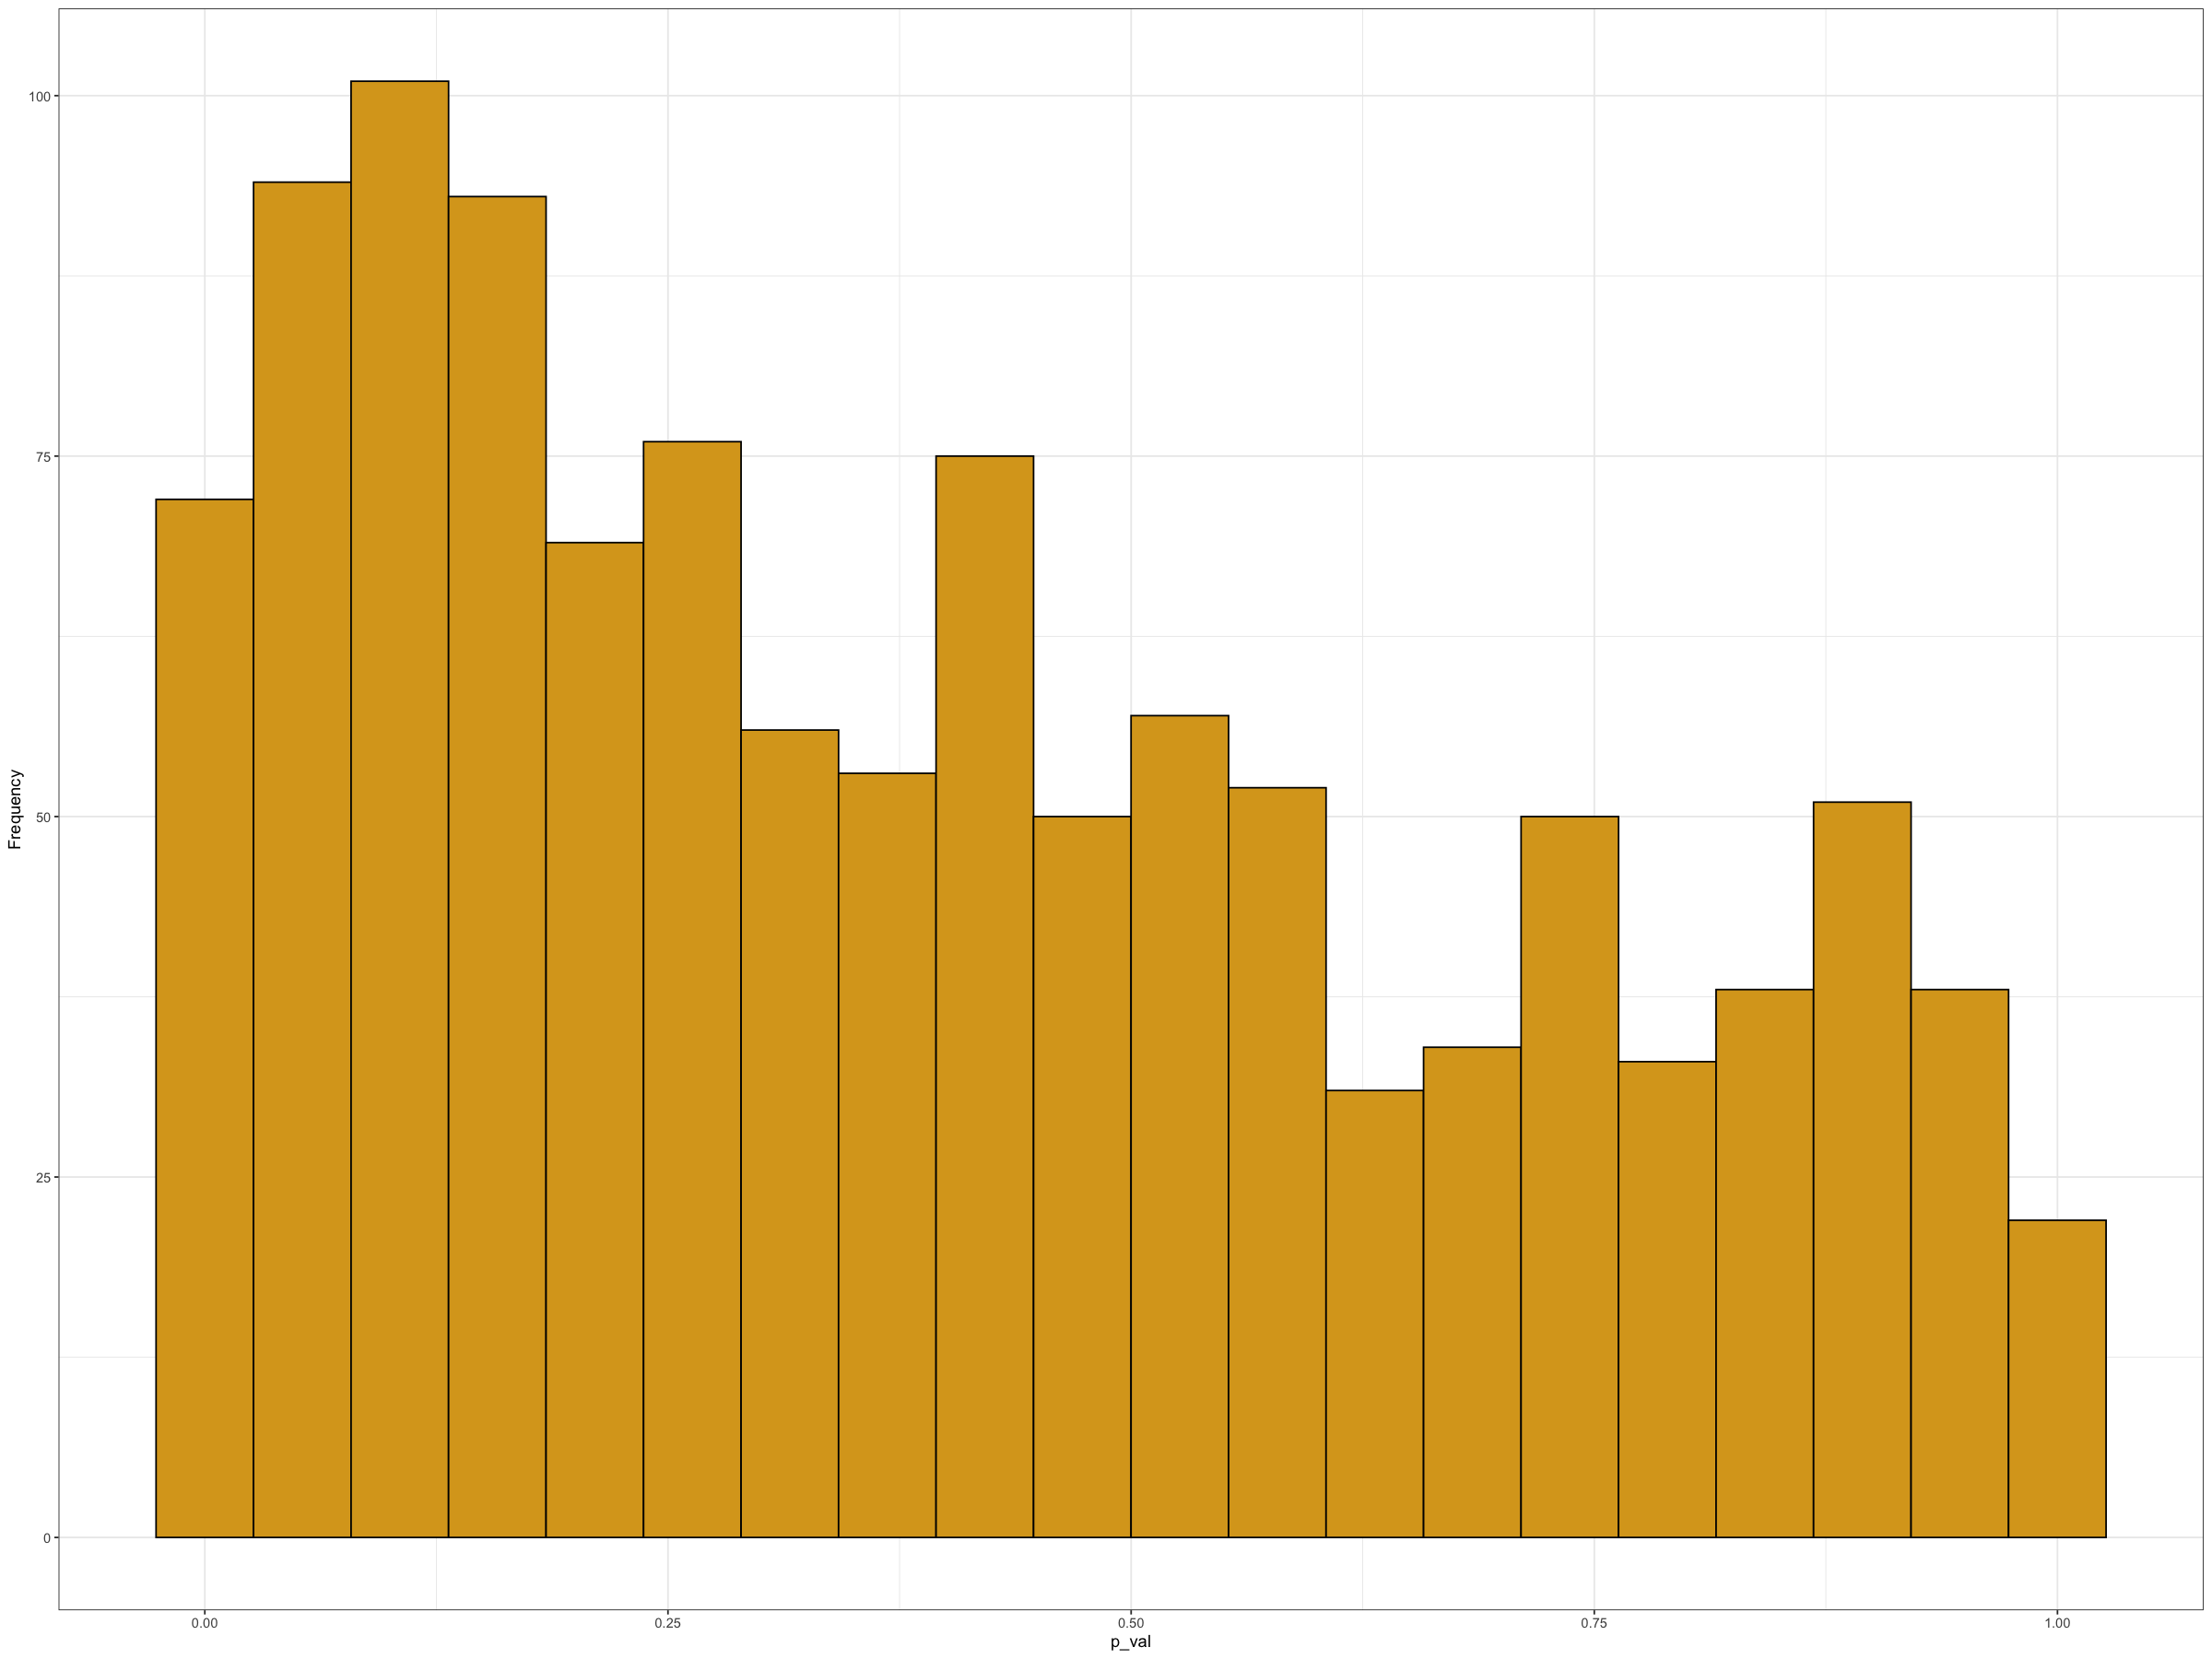

In [29]:
df_pvals_histogram <- ggplot(df_pvals, aes(p_val)) + geom_histogram(bins=20, fill='goldenrod', colour='black') + theme_bw() + ylab("Frequency")
df_pvals_histogram

### Volcano plot:

In [13]:
df_log <- df_pvals %>% select(-c(protein_id,p_val)) %>% log2() 
df_combine <- bind_cols(df_pvals[,c(1)], df_log, df_pvals[,8]) 
head(df_combine)

protein_id,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3,p_val
P38606,-0.4154864,-0.26361160,-0.01612777,-0.6644786,-0.4870821,-0.6500309,0.09273622
P18077,-1.5384016,-1.41407602,-1.40819294,-1.3554361,-1.1470956,-1.1064048,0.07243830
P35580,1.4979274,2.20144044,1.38894261,2.7746465,0.9648915,0.1971525,0.98707595
P84095,-2.9930916,-2.19363469,-3.06914914,-2.6189751,-2.0611998,-2.5504650,0.41922937
P25786,-0.0396860,-0.09354548,-0.42284916,-0.3881666,-0.2396229,-0.0396860,0.80907701
P30044,-0.9298397,-0.93428984,-1.16844700,-0.9364050,0.7201033,0.0493752,0.22076341


In [14]:
df_log_fc <- df_combine %>% 
  group_by(protein_id) %>% 
  mutate(mean_control = mean(c(control_1,
                               control_2,
                               control_3)),
         
         mean_treatment= mean(c(treatment_1,
                                treatment_2,
                                treatment_3)),
         
         log2_fc = mean_control - mean_treatment)

head(df_log_fc)

protein_id,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3,p_val,mean_control,mean_treatment,log2_fc
P38606,-0.4154864,-0.26361160,-0.01612777,-0.6644786,-0.4870821,-0.6500309,0.09273622,-0.2317419,-0.60053053,0.36878861
P18077,-1.5384016,-1.41407602,-1.40819294,-1.3554361,-1.1470956,-1.1064048,0.07243830,-1.4535569,-1.20297883,-0.25057802
P35580,1.4979274,2.20144044,1.38894261,2.7746465,0.9648915,0.1971525,0.98707595,1.6961035,1.31223015,0.38387334
P84095,-2.9930916,-2.19363469,-3.06914914,-2.6189751,-2.0611998,-2.5504650,0.41922937,-2.7519585,-2.41021332,-0.34174517
P25786,-0.0396860,-0.09354548,-0.42284916,-0.3881666,-0.2396229,-0.0396860,0.80907701,-0.1853602,-0.22249185,0.03713163
P30044,-0.9298397,-0.93428984,-1.16844700,-0.9364050,0.7201033,0.0493752,0.22076341,-1.0108588,-0.05564217,-0.95521667


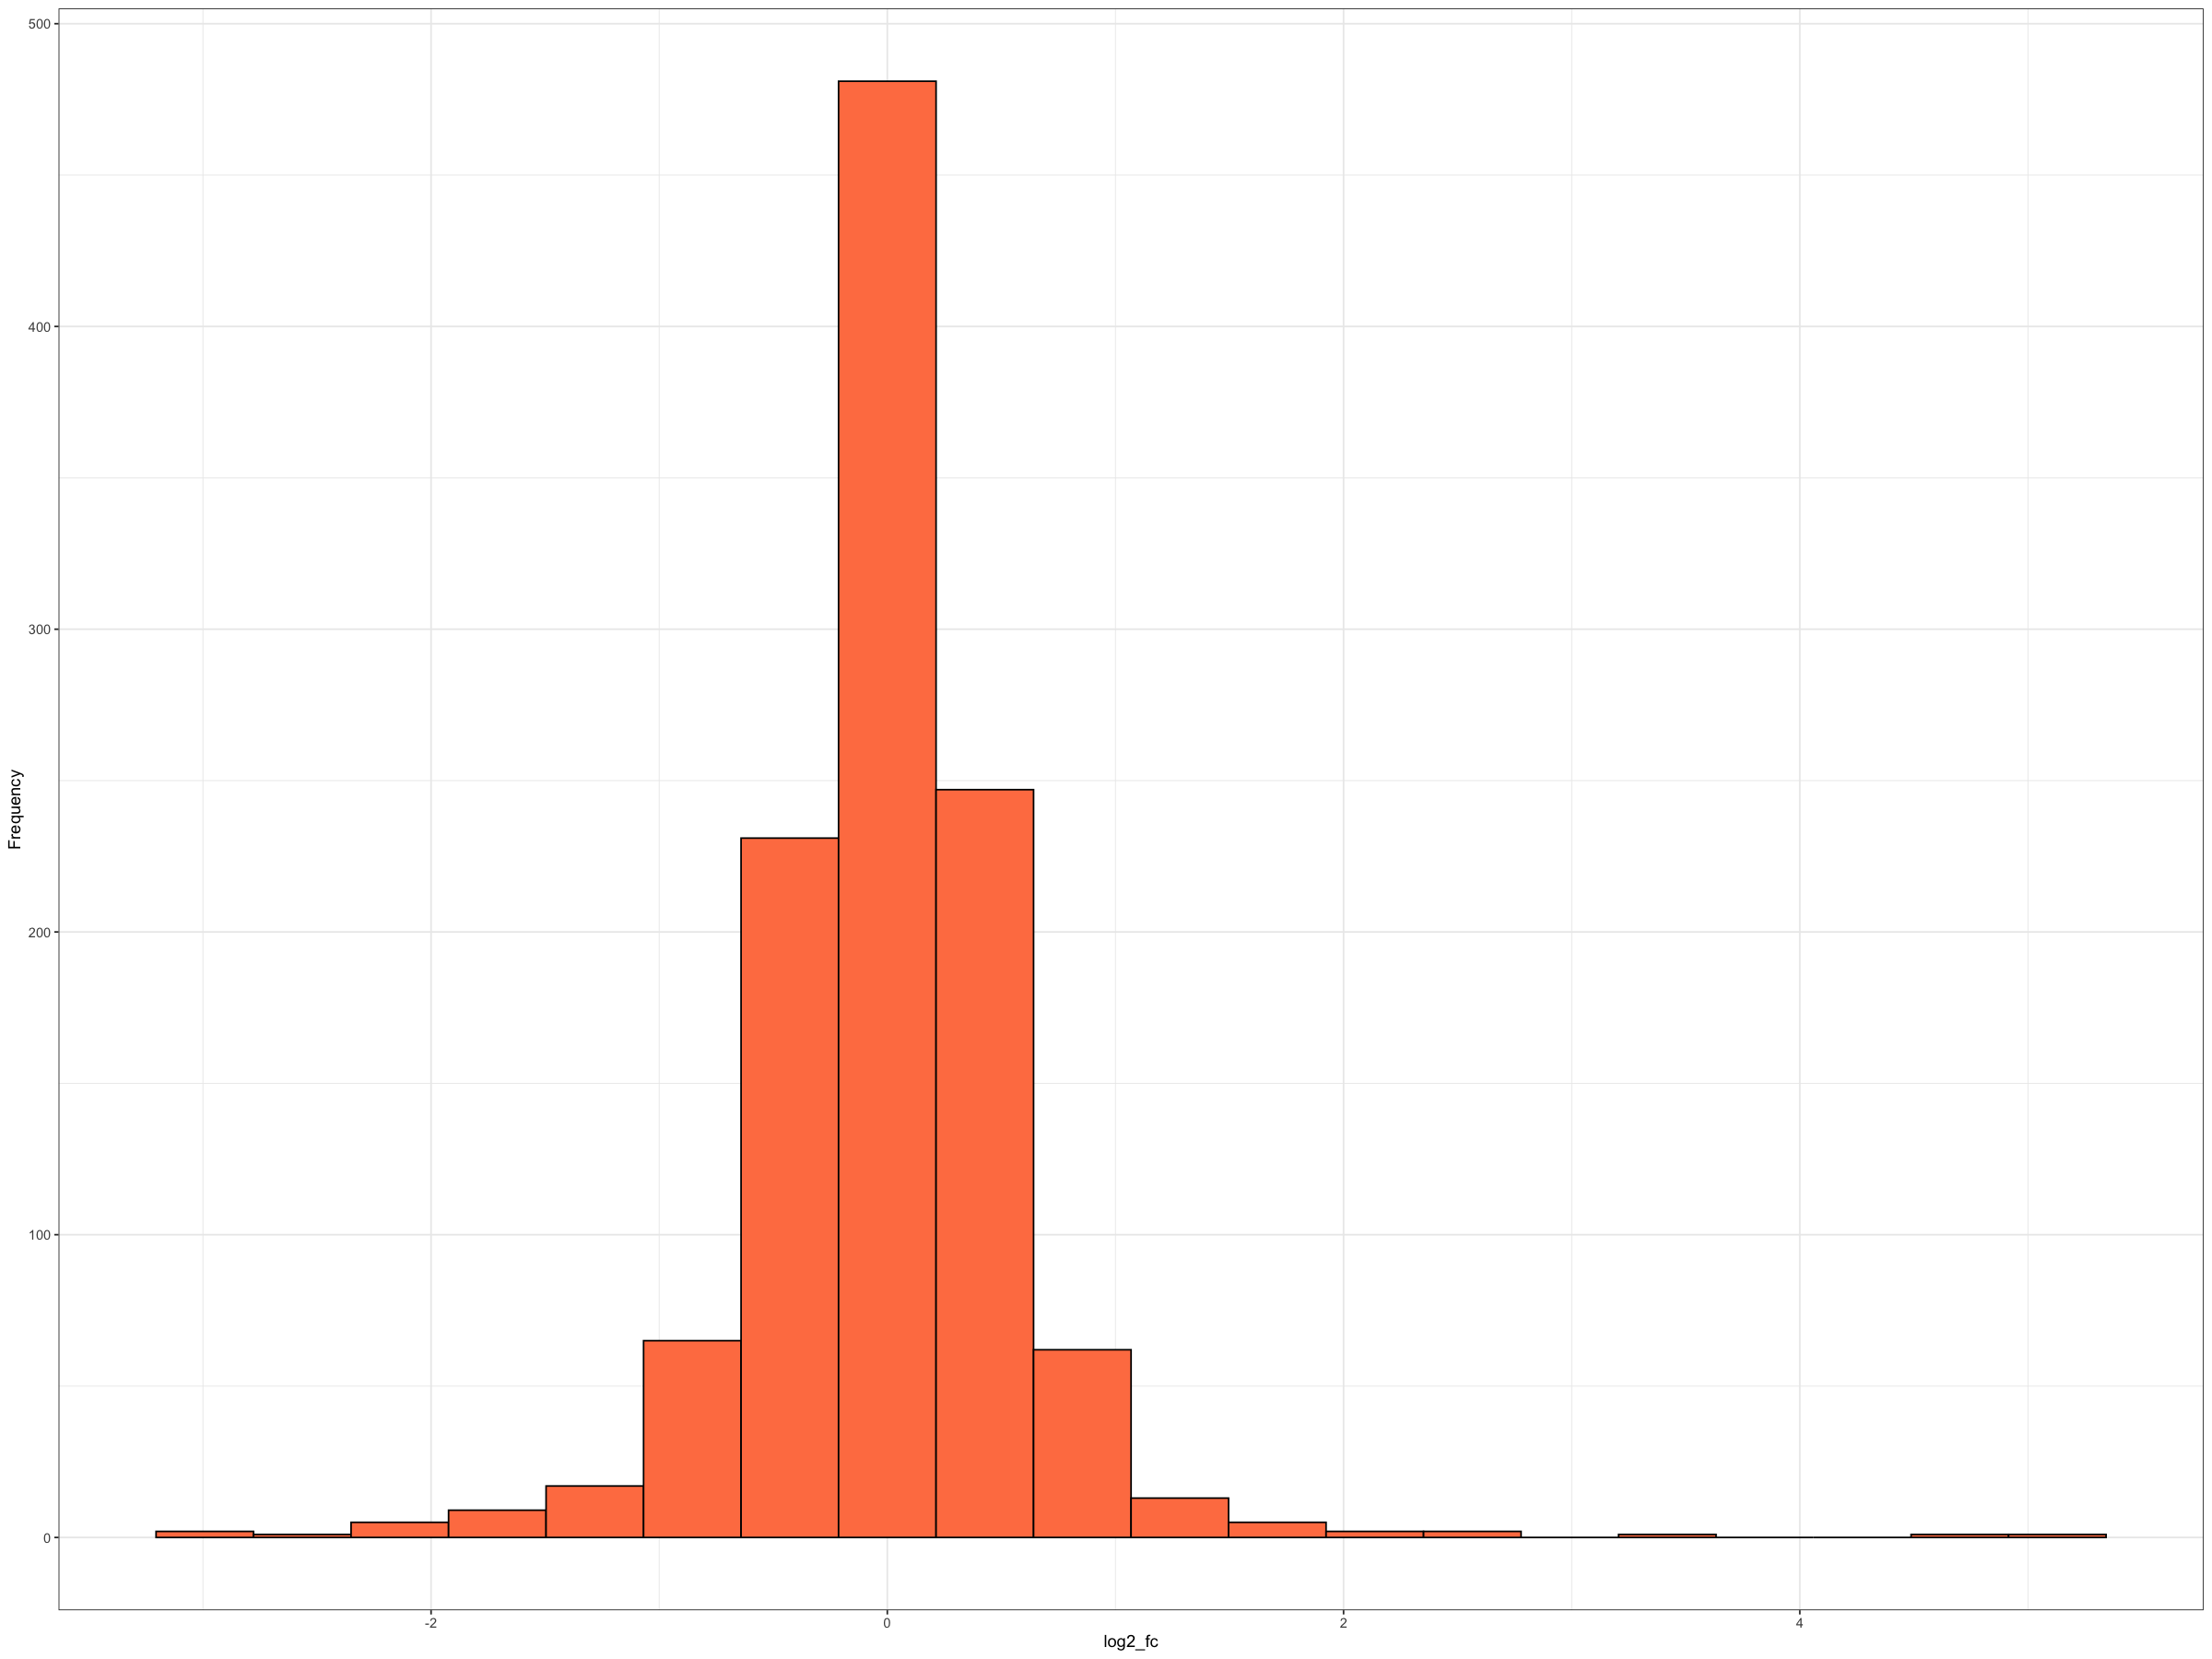

In [31]:
df_log_fc_plot <- ggplot(df_log_fc, aes(log2_fc)) + geom_histogram(bins=20, fill='coral', colour='black') + theme_bw() + ylab("Frequency")
df_log_fc_plot

#We see the treatment generally had no effect since the distribution is skewed to the centre. We do see values to the
#left and the right which means the treatment did have some effect on certain proteins. 
#We can visualize and find these proteins the treatment had an effect on by plotting the log FC vs -log10(pval) - volcano plot

Warning message:
“Removed 1131 rows containing missing values (geom_text_repel).”


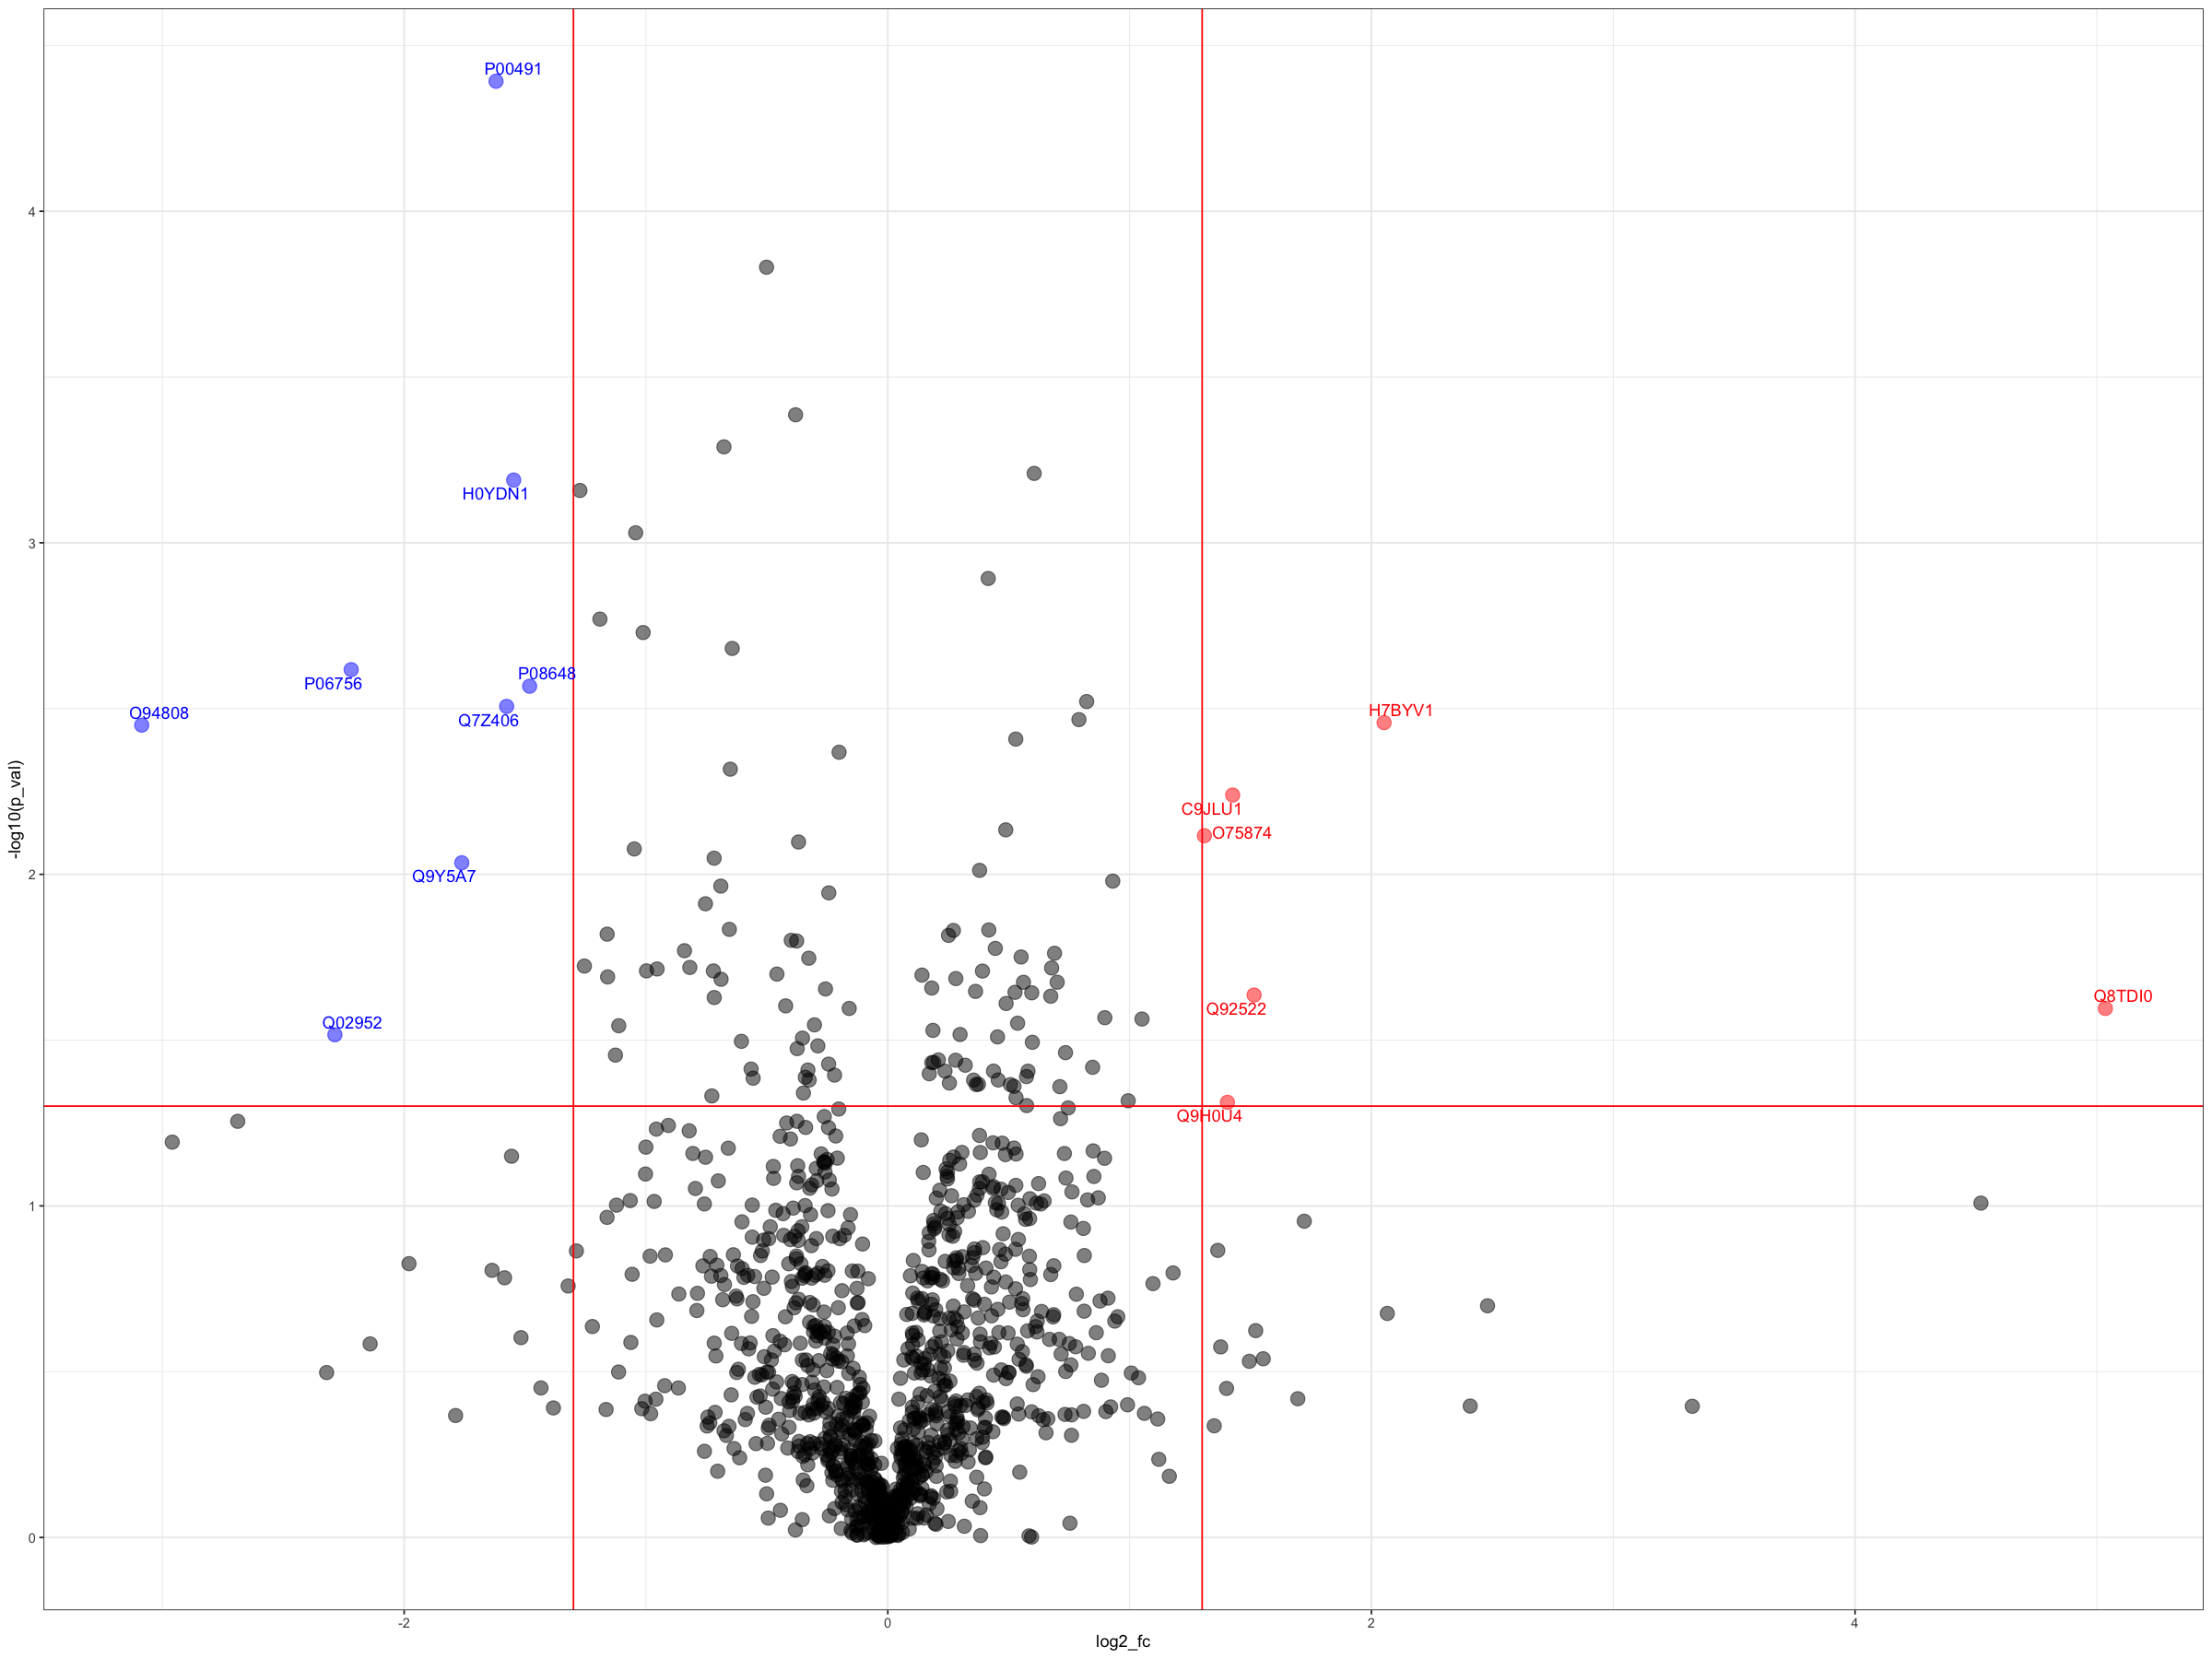

In [38]:
df_log_fc$diffexp <- "NO"
df_log_fc$diffexp[df_log_fc$log2_fc > 1.3 & df_log_fc$p_val < 0.05] <- "UP"
df_log_fc$diffexp[df_log_fc$log2_fc < -1.3 & df_log_fc$p_val < 0.05] <- "DOWN"
df_log_fc$delabel <- NA
df_log_fc$delabel[df_log_fc$diffexp != "NO"] <- df_log_fc$protein_id[df_log_fc$diffexp != "NO"]

volcano_plot <- ggplot(data=df_log_fc, aes(x=log2_fc, y=-log10(p_val), label=delabel, col=diffexp)) + geom_point(alpha = 0.5, size=4) + theme_bw() + scale_color_manual(values=c("blue", "black", "red")) + geom_vline(xintercept=c(-1.3, 1.3), col="red") + geom_hline(yintercept=-log10(0.05), col="red") + theme(legend.position="none") + geom_text_repel()
volcano_plot

Proteins in red and blue are significant observations and the volcano plot shows the respective protein_id for us to investigate. 
Blue -> Treatment reduced the amount of protein 
Red -> Treatment increased the amount of protein 

### Heatmap:
Going to visualize a heatmap for the significant proteins for control and treatment.

In [57]:
df_heatmap <- df_log_fc[df_log_fc$diffexp %in% c("UP", "DOWN"), ]
df_heatmap <- df_heatmap %>% select(protein_id, control_1, control_2, control_3, treatment_1, treatment_2, treatment_3, log2_fc)
df_heatmap <- data.frame(df_heatmap)
df_heatmap <- melt(df_heatmap, id.vars="protein_id")
df_heatmap <- filter(df_heatmap, variable != "log2_fc")

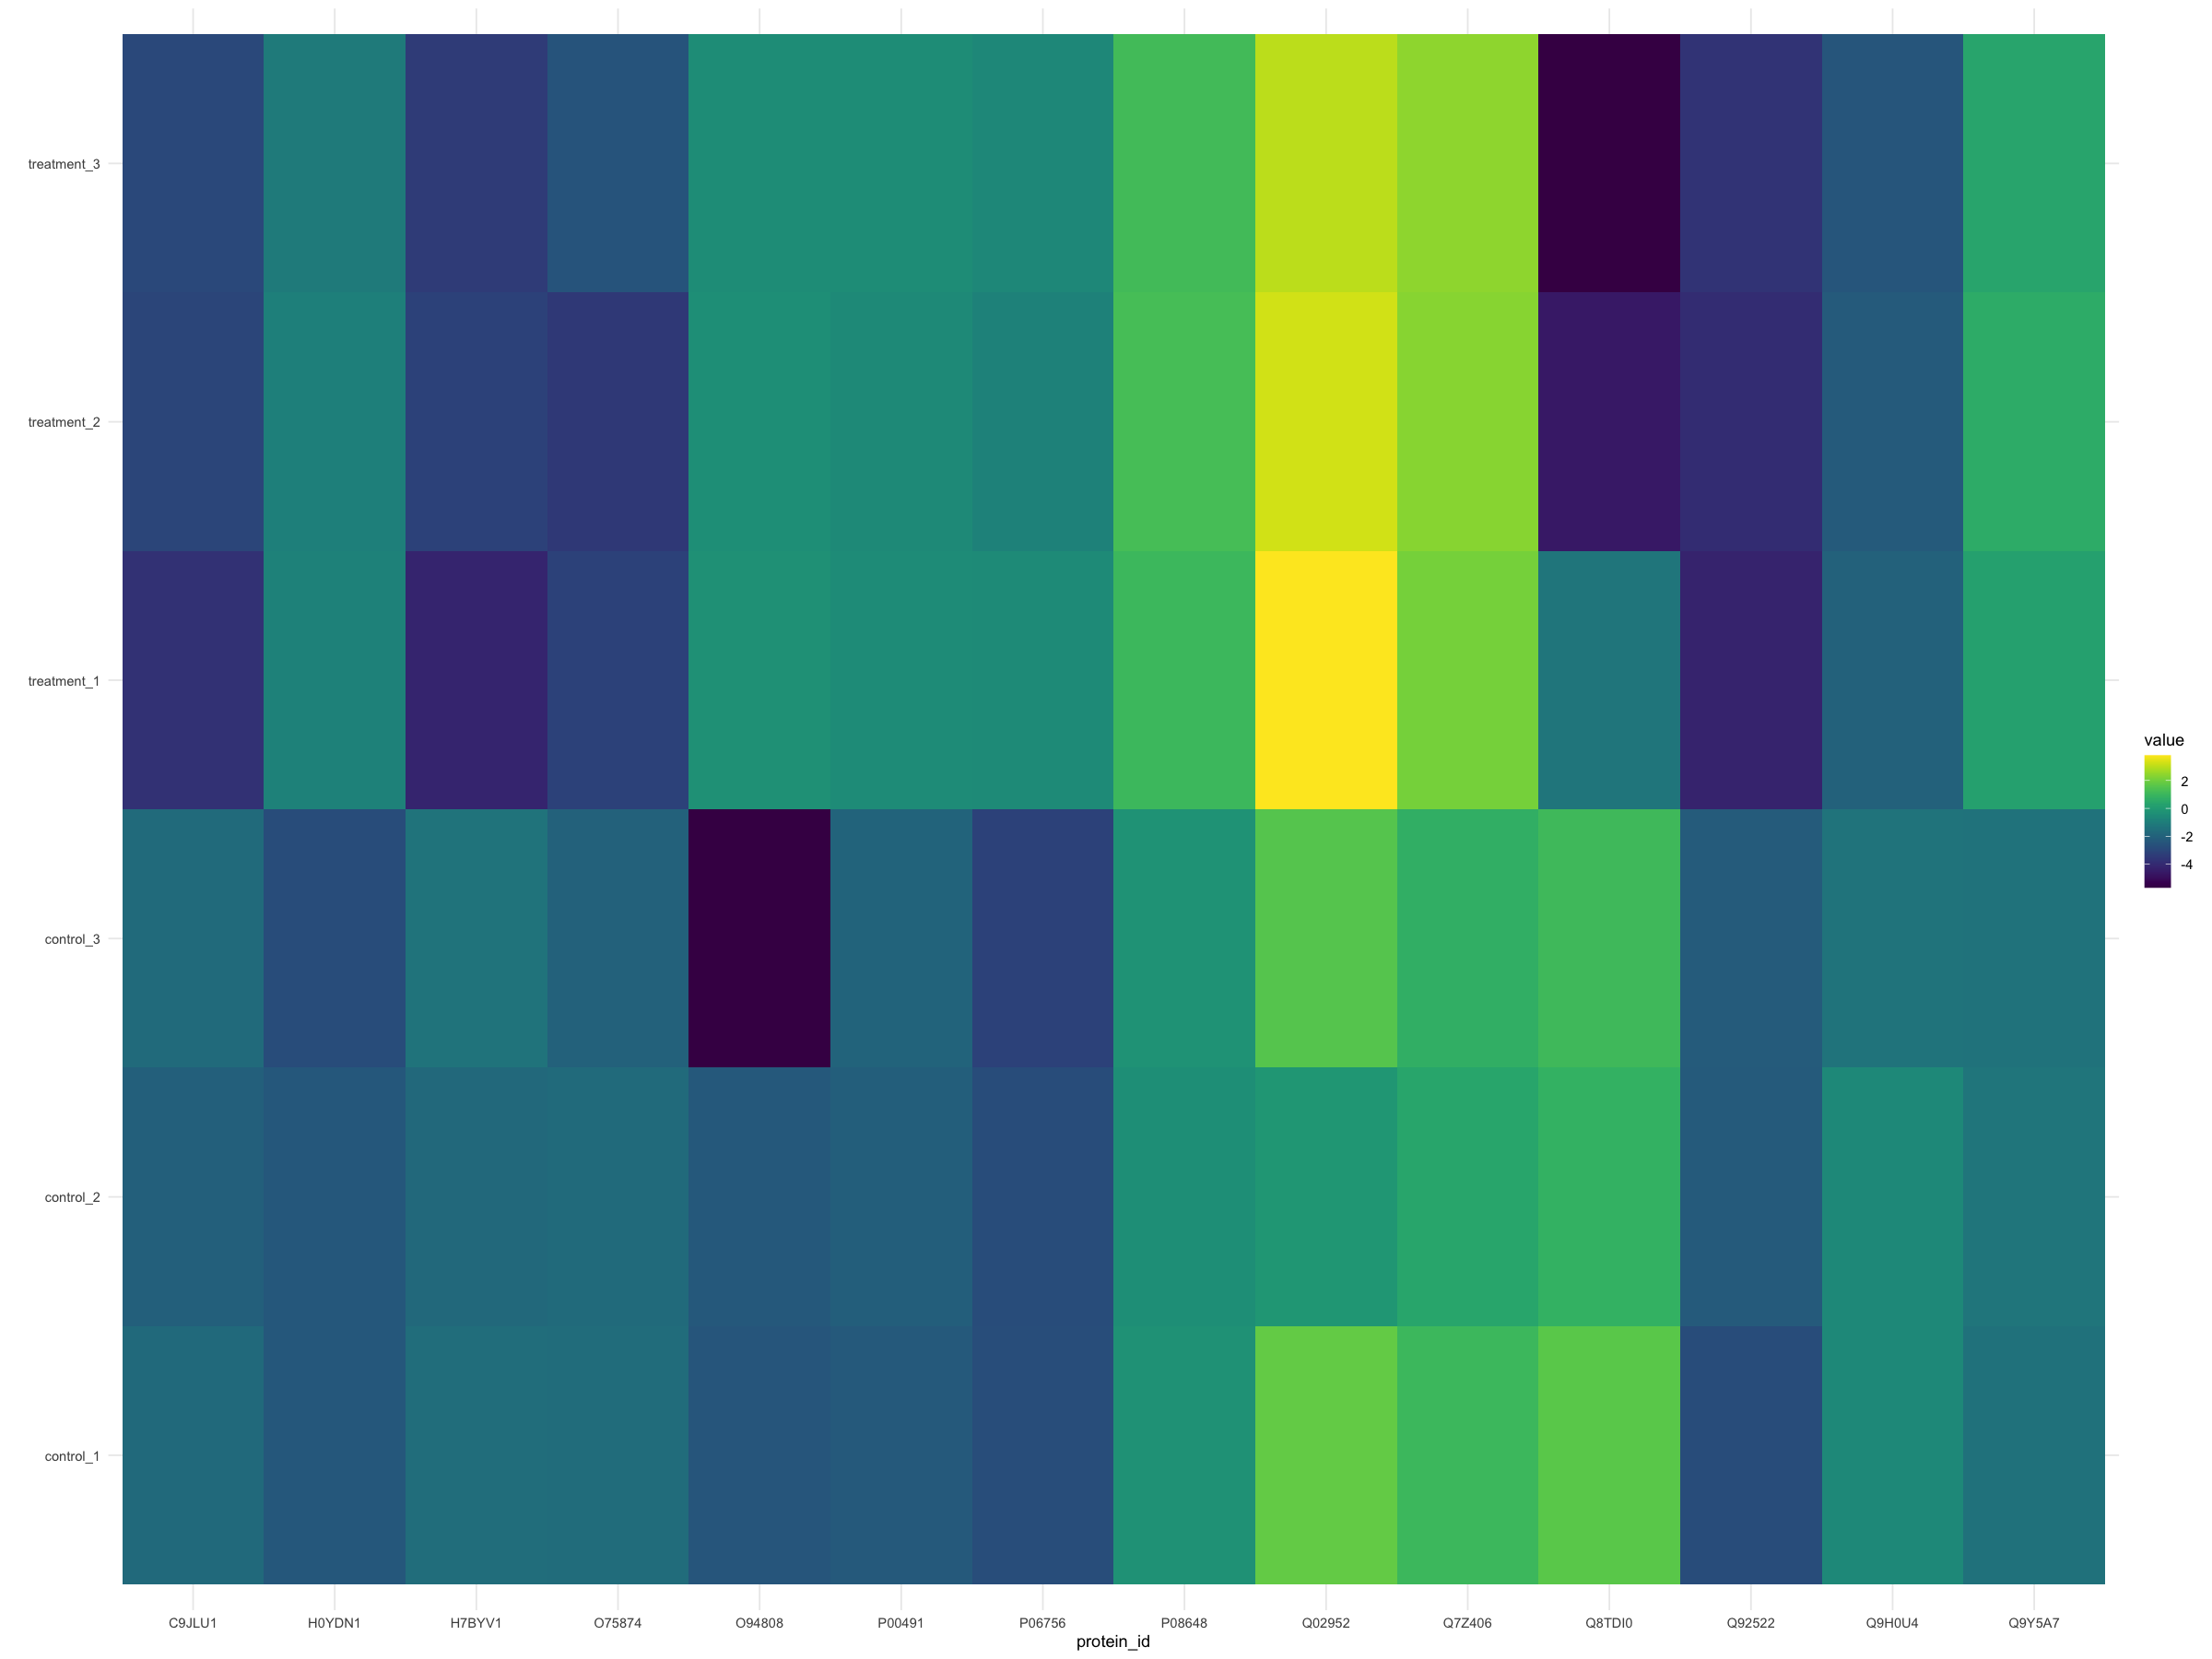

In [70]:
ggplot(df_heatmap, heatmap <- aes(protein_id, variable, fill= value)) + geom_tile() + scale_fill_viridis(discrete=FALSE) + ylab("") + theme_minimal()

Through the data analysis I performed, we can come to the conclusion that the treatment infact did have an effect on the cellular proteome. 

(This was a fun exercise condisering the fact all of the analysis performed is always almost done for gene expression and deriving insights with respect to the gene. Exciting to see that the analysis doesn't stop there and a similar analysis can always be performed at a protein level in order to gain more insight.)